# Datset: Pairwise approach

Get tracksters from a certain neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - figure out how these links are formed

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [1]:
import uproot
import torch
import random
import numpy as np
import awkward as ak

from matplotlib.ticker import FormatStrFormatter

from reco.distance import euclidian_distance
from reco.matching import find_good_pairs
from reco.datasetPU import get_event_pairs
from reco.plotting import plot_tracksters
from reco.event import get_bary_data, get_event_data

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ds_name = "MultiParticle"
file_name = "new_ntuples_15163313_2.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [2]:
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_path)

## Candidate pairs

Compile a list of candidate pairs based on the CLUE3D graph and node distance.

Reject all nodes with above a distance threshold.

In [26]:
eid = 0
dX, dY, _pair_index = get_event_pairs(
    cluster_data,
    trackster_data,
    simtrackster_data,
    assoc_data,
    eid,
    10,
    pileup=False,
    bigT_e_th=50
)


pair_index = np.array(_pair_index)
pos_index = np.array(dY) >= 0.5
neg_index = np.array(dY) < 0.5

# for i, p in  enumerate(_pair_index):
#     print(p, dY[i])

print(sum(pos_index), sum(neg_index))

66 110


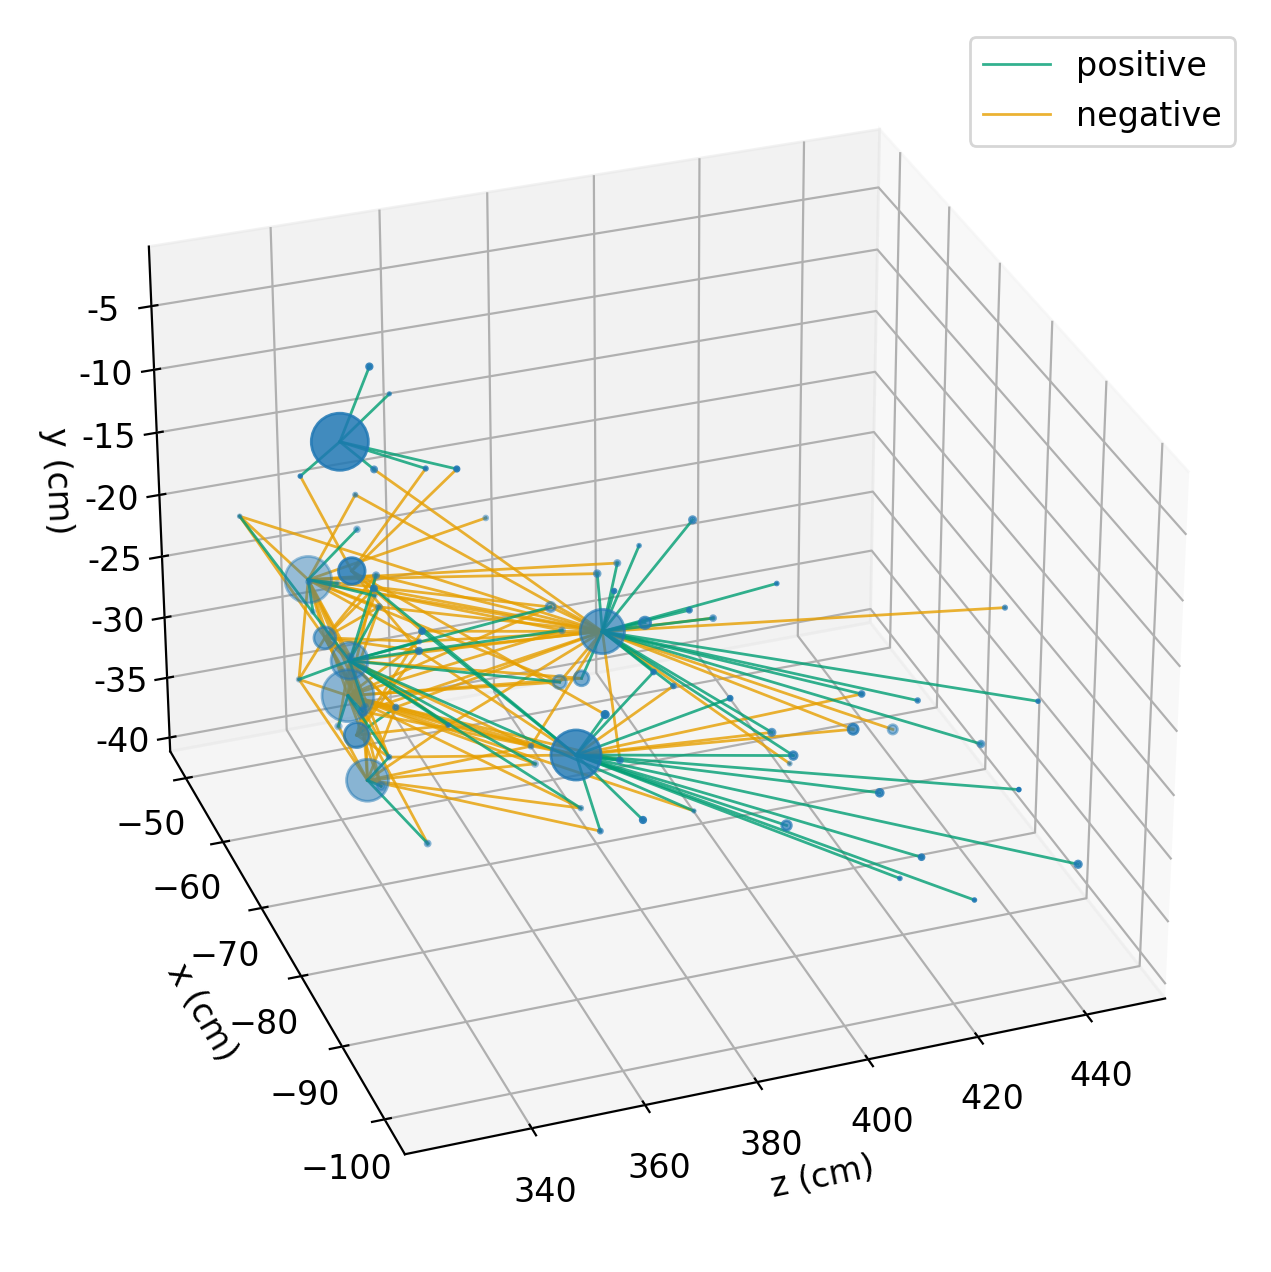

In [27]:
positive = pair_index[pos_index]
negative = pair_index[neg_index]

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111, projection='3d')

all_tx = list(set(ak.flatten(positive).tolist() + ak.flatten(negative).tolist()))

bary = get_bary_data(trackster_data, eid)
ax1.scatter(bary[:,2][all_tx], bary[:,0][all_tx], bary[:,1][all_tx], s=trackster_data["raw_energy"][eid][all_tx])

pos_edges = []
neg_edges = []

def plot_edge(ax, edge, color, label=None):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax1.plot(z, x, y, c=color, linewidth=1, alpha=0.8, label=label) 


plot_edge(ax1, positive[0], "#009E73", "positive")
if len(negative):
    plot_edge(ax1, negative[0], "#E69F00", "negative")
    [plot_edge(ax1, edge, "#E69F00") for edge in negative[1:]]

[plot_edge(ax1, edge, "#009E73") for edge in positive[1:]]

ax1.set_xlabel("z (cm)")
ax1.set_ylabel("x (cm)")
ax1.set_zlabel("y (cm)")
ax1.view_init(elev=30, azim=-110)

ax1.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))


plt.legend()

#fig.savefig('export/photon-PU-pairwise-edges.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Dataset

In [3]:
from reco.datasetPU import TracksterPairs

In [4]:
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=3,
    radius=10,
)
ds.x.shape

torch.Size([71651, 63])

In [5]:
float(sum(ds.y > 0.5) / len(ds.y))

0.5921480655670166

## Dummy evaluation

Let's talk baselines on this dataset. How good is a random guess?
How good is connecting to all nodes in a neighbourhood?

In [6]:
from reco.evaluation import pairwise_model_evaluation
from reco.dummy import DummyPleaser

In [7]:
result = pairwise_model_evaluation(
    cluster_data,
    trackster_data,
    simtrackster_data,
    assoc_data,
    DummyPleaser(),
    decision_th=0.5,
    radius=10,
    max_events=10,
    reco_to_target=False,
)

Event 0:
	clue3d_to_sim:	P: 0.82 R: 0.11 F: 0.13
	target_to_sim:	P: 0.84 R: 0.33 F: 0.38
	reco_to_sim:	P: 0.76 R: 0.34 F: 0.38
Event 1:
	clue3d_to_sim:	P: 0.87 R: 0.10 F: 0.12
	target_to_sim:	P: 0.89 R: 0.17 F: 0.21
	reco_to_sim:	P: 0.85 R: 0.19 F: 0.22
Event 2:
	clue3d_to_sim:	P: 0.85 R: 0.08 F: 0.09
	target_to_sim:	P: 0.88 R: 0.20 F: 0.24
	reco_to_sim:	P: 0.79 R: 0.20 F: 0.23
Event 3:
	clue3d_to_sim:	P: 0.82 R: 0.08 F: 0.10
	target_to_sim:	P: 0.85 R: 0.30 F: 0.35
	reco_to_sim:	P: 0.78 R: 0.31 F: 0.35
Event 4:
	clue3d_to_sim:	P: 0.85 R: 0.07 F: 0.08
	target_to_sim:	P: 0.86 R: 0.14 F: 0.17
	reco_to_sim:	P: 0.81 R: 0.17 F: 0.20
Event 5:
	clue3d_to_sim:	P: 0.90 R: 0.09 F: 0.11
	target_to_sim:	P: 0.92 R: 0.20 F: 0.23
	reco_to_sim:	P: 0.89 R: 0.19 F: 0.23
Event 6:
	clue3d_to_sim:	P: 0.84 R: 0.06 F: 0.07
	target_to_sim:	P: 0.85 R: 0.13 F: 0.16
	reco_to_sim:	P: 0.81 R: 0.23 F: 0.27
Event 7:
	clue3d_to_sim:	P: 0.83 R: 0.07 F: 0.08
	target_to_sim:	P: 0.85 R: 0.32 F: 0.37
	reco_to_sim:	P: 0.78 

# Problems

Sometimes - if a simtrackster is too fragmented, it might not get selected as a big trackster
- we score 0.2 and at least 50% shared energy (or 50GeV)
- if trackster is too fragmented, it might not pass -> then its layerclusters might get stolen
- otherwise: multiple options might pass and then we need to resolve conflicts